The two-spiral problem is shown below.  
--------------------------

###  1. Randomly decompose the two-spiral problem into 4 sub-problems and use a Min-Max Modular neural network to solve the two-spiral problem. Each sub-module is a multilayer quadratic perceptron (MLQP) network with one hidden layer.


In [1]:
#------------ batch learning for MLQPs -----------#
import numpy as np

class QP:
    def __init__(self,n_input,n_output):
        self.U=np.random.uniform(0,1,(n_input,n_output))
        self.V=np.random.uniform(0,1,(n_input,n_output))
        self.one=np.ones((n_output))
        
    def forward(self,x):
        # x: 1 x n_input
        t=np.dot(x**2,self.U)+np.dot(x,self.V)
        self.s=1/(1+np.exp(-t))
        y=self.s
        return y
    
    def backward(self,x,gy,lr):
        # gt: 1 x n_output
        gt=gy*self.s*(self.one-self.s) #1 x n_output
        #print 'gt', gt.shape, 'V',self.V.T.shape,'x',x.shape
        gx=np.dot(gt,self.U.T)*2*x + np.dot(gt,self.V.T)
        gU=np.dot((x**2).T,gt) # n_input x 1 and 1 x n_output -->n_i x n_o
        gV=np.dot(x.T,gt)
        
        #update
        self.U=self.U-lr*gU
        self.V=self.V-lr*gV
        
        return gx
        
class MLQPs:
    def __init__(self, foo, n_input,n_output,n_hidden=10):
        #self.W=np.random.uniform(0,1,(c,d+1))  # cxd
        self.qp1=QP(n_input+1,n_hidden)
        self.qp2=QP(n_hidden,n_output)

        self.foo = foo
        
    def forward(self,x): #nxd
        h=self.qp1.forward(x)
        pred=self.qp2.forward(h)
        return h,pred 
    
    def train(self,X,Y,batch_size=10,learning_rate=0.05,training_epoches=2000,display_epoch=500):
        n=X.shape[0]
        X=np.hstack((X,np.ones((n,1)))) 
        batch_num=n/batch_size
        for epoch in np.arange(training_epoches):
            for i in range(batch_num):
                x= X[i*batch_size:(i+1)*batch_size,:]
                y= Y[i*batch_size:(i+1)*batch_size,:]
                h,pred = self.forward(x) 
                diff = pred-y
                cost = np.linalg.norm(diff)
                # out layer
                gh = self.qp2.backward(h,diff,learning_rate)
                # hidden layer
                self.qp1.backward(x,gh,learning_rate)
            if epoch%display_epoch==0:
                print 'mlqps id :%d'% self.foo, 'epoch: %d' % epoch,'cost: %f' % cost

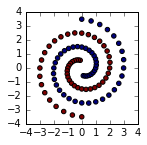

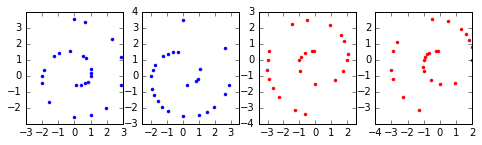

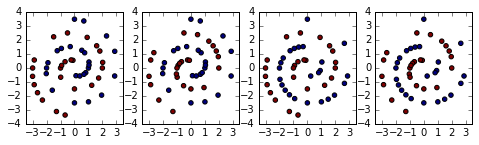

In [4]:
#------------------- randomly decompose the problem into 4 sub-problem -----------------#

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# ------- load training data
train_path='data/two_spiral_train.txt'
train_data=np.loadtxt(train_path)

# plot
plt.figure(figsize=(2,2))
plt.scatter(train_data[:,0],train_data[:,1],c=train_data[:,2])
plt.axis('equal')

# ------------
# each seperate to two balance sub randomly
# seperate 0,1 classes
c = 0
data = {}
for i in range(2):
    tmp = train_data[train_data[:,2]==i] # 0 1
    for j in range(2):
        index = np.random.permutation(tmp.shape[0])
        data[c] = tmp[index[:tmp.shape[0]/2],:]
        c += 1
# 
plt.figure(figsize=(8,2))
for i in range(4):
    plt.subplot(1,4,i+1)
    if i<2:
        plt.plot(data[i][:,0],data[i][:,1],'b.') # 0
    else:
        plt.plot(data[i][:,0],data[i][:,1],'r.') # 1
    plt.axis('equal')

# ---------
# randomly decompose into 4 sub
c = 0
D = {}
for i in range(2):
    d0 = data[i] # 0 1
    for j in range(2):
        d1 = data[j+2]
        tmp = np.vstack((d0,d1))
        index = np.random.permutation(tmp.shape[0])
        D[c] = tmp[index]
        c += 1
# 
plt.figure(figsize=(8,2))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.scatter(D[i][:,0],D[i][:,1],c=D[i][:,2])
    plt.axis('equal')

In [10]:
# ---------Each sub-module is a multilayer quadratic perceptron (MLQP) network with one hidden layer.-------------#

# ------training 4 mlqps parallelly
from multiprocessing import Pool
import os, time

def train_mlqps(X, Y, flag):
    print('Run task %s (%s)...' % (flag, os.getpid()))
    start = time.time()
    mlqps = MLQPs(flag,n_input=X.shape[1],n_output=Y.shape[1],n_hidden=10) 
    mlqps.train(X,Y,learning_rate=0.5,training_epoches=8e4, display_epoch=3e4)
    end = time.time()
    print('Task %s runs %0.2f seconds.' % (flag, (end - start)))
    return mlqps

print('Parent process %s.' % os.getpid())
p = Pool(4) # 4 process
result=[]
for i in range(4):
    data = D[i]
    X = data[:,:2]
    Y = data[:,-1:]
    result.append(p.apply_async(train_mlqps, (X,Y,i)))
p.close()
p.join()
mlqps_dict = {}
for ind,res in enumerate(result):
    mlqps_dict[ind] = res.get()
print('training done.')

Parent process 4888.
Run task 0 (5074)...
Run task 1 (5075)...
Run task 3 (5086)...
Run task 2 (5076)...
mlqps id :0 epoch: 0 cost: 0.999965
mlqps id :1 epoch: 0 cost: 0.999802
mlqps id :2 epoch: 0 cost: 1.731920
mlqps id :3 epoch: 0 cost: 2.235873
mlqps id :2 epoch: 30000 cost: 0.010180
mlqps id :3 epoch: 30000 cost: 0.006685
mlqps id :1 epoch: 30000 cost: 0.010498
mlqps id :0 epoch: 30000 cost: 0.011267
mlqps id :2 epoch: 60000 cost: 0.006908
mlqps id :0 epoch: 60000 cost: 0.007763
mlqps id :3 epoch: 60000 cost: 0.004717
mlqps id :1 epoch: 60000 cost: 0.007299
Task 2 runs 14.61 seconds.
Task 0 runs 14.99 seconds.
Task 3 runs 15.48 seconds.
Task 1 runs 15.88 seconds.
training done.


In [11]:
# ---------------use a Min-Max Modular neural network to solve the two-spiral problem. ---------------------------#

def MM_predict(mdict, X):
    yd = {}
    for k in range(4):
        _,pred = mdict[k].forward(X)
        pred[pred>=0.5]=1
        pred[pred<0.5]=0
        yd[k]=pred.astype(int)
    pred = (yd[0] & yd[2])| (yd[1] & yd[3])  # Min Max
    return pred

# test
test_path='../two_spiral_test.txt'
test_data=np.loadtxt(test_path)
X_test=test_data[:,:2]
Y_test=test_data[:,-1:].astype(int)
X_test=np.hstack((X_test,np.ones((X_test.shape[0],1))))

pred = MM_predict(mlqps_dict,X_test)
correct = np.sum(pred==Y_test)
acc=float(correct)/Y_test.shape[0]

print 'test accuracy with Min-Max Modular neural network : ',str(acc*100),'%'

test accuracy with Min-Max Modular neural network :  97.9166666667 %


*************

### 2. Plot the decision boundaries of each trained sub-module and the Min-Max Modular neural network.

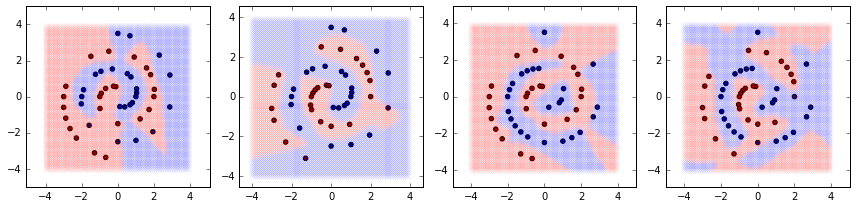

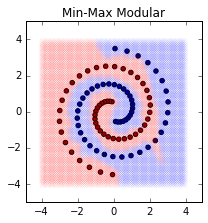

In [12]:
# ----------- visualize the result ---------------#
def visualize_mlqp(model,X,Y):
    x1=np.arange(-4,4,0.1)
    x2=x1
    for i in x1:
        for j in x2:
            _,y=model.forward(np.array([i,j,1]))
            if y>=0.5:
                plt.plot(i,j,'rx',alpha=0.1)
            else:
                plt.plot(i,j,'bx',alpha=0.1)
    plt.scatter(X[:,0],X[:,1],c=Y)
    plt.axis('equal')
    plt.tight_layout()
    #plt.show()
    
def visualize_all(mdict,X,Y):
    x1=np.arange(-4,4,0.1)
    x2=x1
    for i in x1:
        for j in x2:
            y = MM_predict(mlqps_dict,np.array([i,j,1]))
            if y>=0.5:
                plt.plot(i,j,'rx',alpha=0.1)
            else:
                plt.plot(i,j,'bx',alpha=0.1)
    plt.scatter(X[:,0],X[:,1],c=Y)
    plt.axis('equal')
    plt.tight_layout()

# plot the decision boundaries of each trained sub-module
plt.figure(figsize=(12,3))
for i in range(4):    
    plt.subplot(1,4,i+1)
    visualize_mlqp(mlqps_dict[i], D[i][:,:2], D[i][:,-1])
    
# plot the decision boundaries of the Min-Max Modular neural network.
plt.figure(figsize=(3,3))
visualize_all(mlqps_dict,X_test,Y_test)
plt.title('Min-Max Modular')

************ 

### 3. Compare the training time and generalization performance of the above Min-Max Modular neural network and the single MLQP networks trained in Homework Assignment 1.

#### a. The training time:  
    Min-Max Modular neural network can train sub-module parallelly, so the training time can be about 1/4 of the single MLQP networks when we decompose the two-spiral problem into 4 sub-problems.  

#### b. The generalization performance:  
    In homework assignment 1, the test result of single MLQP networks is exactly correct, while the precision rate of Min-Max Modular neural network is about 98%, so, just for the training and test data of the two-spiral problem, the generalization performance of single MLQP networks is better.